# Notebook Styling: Please do not edit

In [1]:
#import os
#os.system ("pip install keras==2.4.3")

#!pip install tensorflow

import keras
print('The keras version is {}.'.format(keras.__version__))

2023-02-22 18:18:47.332373: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-22 18:18:47.447821: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-22 18:18:47.452463: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-22 18:18:47.452479: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [2]:
# IPython display functions
import IPython
from IPython.display import display, HTML, SVG, Image

# General Plotting
import matplotlib.pyplot as plt

plt.style.use('seaborn-paper')
plt.rcParams['figure.figsize'] = [10, 6] ## plot size
plt.rcParams['axes.linewidth'] = 2.0 #set the value globally

## notebook style and settings
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_png { display: table-cell; text-align: center; vertical-align: middle; } </style>"))
display(HTML("<style>.MathJax {font-size: 100%;}</style>"))

# For changing background color
def set_background(color):
    script = ( "var cell = this.closest('.code_cell');" "var editor = cell.querySelector('.input_area');" "editor.style.background='{}';" "this.parentNode.removeChild(this)" ).format(color)
    display(HTML('<img src onerror="{}">'.format(script)))

Library Imports

In [3]:
import os
import sys
import random
import numpy as np
import pandas as pd
from os import walk

# Metrics
from sklearn.metrics import *

# Keras library for deep learning
# https://keras.io/
import tensorflow as tf
import keras
from keras.datasets import mnist # MNIST Data set
from keras.models import Sequential # Model building
from keras.layers import * # Model layers
from keras.preprocessing.image import *
from tensorflow.keras.utils import *
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# 1. Helper Functions

## 1.1 Confusion Matrix
Confusion matrices are an important toolkit in every data scientist's box. We have created a function for you that you can use to create visual confusion matrices and analyze your models.

In [4]:
def displayConfusionMatrix(confusionMatrix, precisionNegative, precisionPositive, recallNegative, recallPositive, title):
    # Set font size for the plots. You can ignore this line.
    PLOT_FONT_SIZE = 14
    
    # Set plot size. Please ignore this line
    plt.rcParams['figure.figsize'] = [5, 5]
    
    # Transpose of confusion matrix to align the plot with the actual precision recall values. Please ignore this as well.
    confusionMatrix = np.transpose(confusionMatrix)
    
    # Plotting the confusion matrix
    plt.imshow(confusionMatrix, interpolation='nearest',cmap=plt.cm.Blues, vmin=0, vmax=100)
    
    
    # Setting plot properties. You should ignore everything from here on.
    xticks = np.array([-0.5, 0, 1,1.5])
    plt.gca().set_xticks(xticks)
    plt.gca().set_yticks(xticks)
    plt.gca().set_xticklabels(["", "Healthy\nRecall=" + str(recallNegative) , "Pneumonia\nRecall=" + str(recallPositive), ""], fontsize=PLOT_FONT_SIZE)
    plt.gca().set_yticklabels(["", "Healthy\nPrecision=" + str(precisionNegative) , "Pneumonia\nPrecision=" + str(precisionPositive), ""], fontsize=PLOT_FONT_SIZE)
    plt.ylabel("Predicted Class", fontsize=PLOT_FONT_SIZE)
    plt.xlabel("Actual Class", fontsize=PLOT_FONT_SIZE)
    plt.title(title, fontsize=PLOT_FONT_SIZE)
        
    # Add text in heatmap boxes
    for i in range(2):
        for j in range(2):
            text = plt.text(j, i, confusionMatrix[i][j], ha="center", va="center", color="white", size=15) ### size here is the size of text inside a single box in the heatmap
            
    plt.show()

In [5]:
def calculateMetrics(predictions, predictionsProbabilities, actualLabels):
    # Convert label format from [0,1](label 1) and [1,0](label 0) into single integers: 1 and 0.
    actualLabels = [item[1] for item in actualLabels]
    
    # Get probabilities for the class with label 1. That is all we need to compute AUCs. We don't need probabilities for class 0.
    predictionsProbabilities = [item[1] for item in predictionsProbabilities]
    
    # Calculate metrics using scikit-learn functions. The round function is used to round the numbers up to 2 decimal points.
    try:
        accuracy = round(accuracy_score(actualLabels, predictions) * 100, 2)
        precisionNegative = round(precision_score(actualLabels, predictions, average = None)[0] * 100, 2)
        precisionPositive = round(precision_score(actualLabels, predictions, average = None)[1] * 100, 2)
        recallNegative = round(recall_score(actualLabels, predictions, average = None)[0] * 100, 2)
        recallPositive = round(recall_score(actualLabels, predictions, average = None)[1] * 100, 2)
    except:
        print("An exception occurred but was caught.")
    auc = round(roc_auc_score(actualLabels, predictionsProbabilities) * 100, 2)
    
    return auc

## 1.2 Metrics Calculation
We are giving you a function that will calculate all the metrics you'll need in order to analyze your model

In [6]:
def calculateMetricsAndPrint(predictions, predictionsProbabilities, actualLabels):
    # Convert label format from [0,1](label 1) and [1,0](label 0) into single integers: 1 and 0.
    actualLabels = [item[1] for item in actualLabels]
    
    # Get probabilities for the class with label 1. That is all we need to compute AUCs. We don't need probabilities for class 0.
    predictionsProbabilities = [item[1] for item in predictionsProbabilities]
    
    # Calculate metrics using scikit-learn functions. The round function is used to round the numbers up to 2 decimal points.
    accuracy = round(accuracy_score(actualLabels, predictions) * 100, 2)
    precisionNegative = round(precision_score(actualLabels, predictions, average = None)[0] * 100, 2)
    precisionPositive = round(precision_score(actualLabels, predictions, average = None)[1] * 100, 2)
    recallNegative = round(recall_score(actualLabels, predictions, average = None)[0] * 100, 2)
    recallPositive = round(recall_score(actualLabels, predictions, average = None)[1] * 100, 2)
    auc = round(roc_auc_score(actualLabels, predictionsProbabilities) * 100, 2)
    confusionMatrix = confusion_matrix(actualLabels, predictions)
    
    # Print metrics. .%2f prints a number upto 2 decimal points only.
    print("------------------------------------------------------------------------")
    print("Accuracy: %.2f\nPrecisionNegative: %.2f\nPrecisionPositive: %.2f\nRecallNegative: %.2f\nRecallPositive: %.2f\nAUC Score: %.2f" % 
          (accuracy, precisionNegative, precisionPositive, recallNegative, recallPositive, auc))
    print("------------------------------------------------------------------------")
    
    print("+ Printing confusion matrix...\n")
    # Display confusion matrix
    displayConfusionMatrix(confusionMatrix, precisionNegative, precisionPositive, recallNegative, recallPositive, "Confusion Matrix")
    
    print("+ Printing ROC curve...\n")
    # ROC Curve
    plt.rcParams['figure.figsize'] = [16, 8]
    FONT_SIZE = 16
    falsePositiveRateDt, truePositiveRateDt, _ = roc_curve(actualLabels, predictionsProbabilities)
    plt.plot(falsePositiveRateDt, truePositiveRateDt, linewidth = 5, color='black')
    plt.xticks(fontsize=FONT_SIZE)
    plt.yticks(fontsize=FONT_SIZE)
    plt.xlabel("False Positive Rate", fontsize=FONT_SIZE)
    plt.ylabel("True Positive Rate", fontsize=FONT_SIZE)
    plt.show()
    
    return auc

## 1.3 Kaggle Predictions

In [7]:
def getKagglePredictions(model, kaggleData, filename):
    print("+ Writing kaggle test results in : results/%s..." % filename)
    predictions = model.predict(kaggleData)
    predictionProbs = [item[1] for item in predictions]
        
    # Store predictions for kaggle
    outputFile = open("results/" + str(filename), "w")
    outputFile.write("Id,Prediction\n")
    for i in range(0, len(predictionProbs)):
        outputFile.write(str(i + 1) + "," + str(predictionProbs[i]) + "\n")
    
    outputFile.close()

## 1.4 Top n% accuracy

In [8]:
def calculateClasswiseTopNAccuracy(actualLabels, predictionsProbs, TOP_N):
    """
    TOP_N is the top n% predictions you want to use for each class
    """

    discreteActualLabels = [1 if item[1] > item[0] else 0 for item in actualLabels]
    discretePredictions = [1 if item[1] > item[0] else 0 for item in predictionsProbs]
    predictionProbsTopNHealthy, predictionProbsTopNPneumonia = [item[0] for item in predictionsProbs], [item[1] for item in predictionsProbs]
    predictionProbsTopNHealthy = list(reversed(sorted(predictionProbsTopNHealthy)))[:int(len(predictionProbsTopNHealthy) * TOP_N / 100)][-1]
    predictionProbsTopNPneumonia = list(reversed(sorted(predictionProbsTopNPneumonia)))[:int(len(predictionProbsTopNPneumonia) * TOP_N / 100)][-1]

    # Calculate accuracy for both classes
    accuracyHealthy = []
    accuracyPneumonia = []
    for i in range(0, len(discretePredictions)):
        if discretePredictions[i] == 1:
            # Pneumonia
            if predictionsProbs[i][1] > predictionProbsTopNPneumonia:
                accuracyPneumonia.append(int(discreteActualLabels[i]) == 1)
        else:
            # Healthy
            if predictionsProbs[i][0] > predictionProbsTopNHealthy:
                accuracyHealthy.append(int(discreteActualLabels[i]) == 0)

    accuracyHealthy = round((accuracyHealthy.count(True) * 100) / len(accuracyHealthy), 2)
    accuracyPneumonia = round((accuracyPneumonia.count(True) * 100) / len(accuracyPneumonia), 2)
    return accuracyHealthy, accuracyPneumonia

# 2. Data Loading
## 2.1 Loading File Paths
We will first load file paths from normal and pneumonia folders in the train directory.

In [9]:
# Load normal images
normalImagesPath = "data/train/normal"
normalImageFiles = []
for(_,_,files) in walk(normalImagesPath):
    normalImageFiles.extend(files)

normalImagesPath2 = "data/train/normal2"
for(_,_,files) in walk(normalImagesPath2):
    normalImageFiles.extend(files)

print(len(normalImageFiles))

# Load pneumonia images
pneumoniaImagesPath = "data/train/pneumonia"
pneumoniaImageFiles = []
for(_,_,files) in walk(pneumoniaImagesPath):
    pneumoniaImageFiles.extend(files)
    
random.shuffle(pneumoniaImageFiles)
pneumoniaImageFiles = pneumoniaImageFiles[:len(normalImageFiles)]
print("Normal X-ray images: %d\nPneumonia X-ray images: %d" % (len(normalImageFiles), len(pneumoniaImageFiles)))

1436
Normal X-ray images: 1436
Pneumonia X-ray images: 1436


## 2.2 Loading Image Data
### 2.2.1 Training and Validation

In [10]:
imagesData = []
imagesLabels = []

for file in normalImageFiles:
    fullPath = normalImagesPath + "/" + file
    if os.path.exists(fullPath) == False:
            continue
    imageData = load_img(normalImagesPath + "/" + file, color_mode = "grayscale") # load_img function comes from keras library when we do "from keras.preprocessing.image import *"
    imageArray = img_to_array(imageData) / 255.0
    
    imagesData.append(imageArray)
    imagesLabels.append(0)
    

for file in pneumoniaImageFiles:
    fullPath = pneumoniaImagesPath + "/" + file
    if os.path.exists(fullPath) == False:
            continue
            
    imageData = load_img(pneumoniaImagesPath + "/" + file, color_mode = "grayscale") # load_img function comes from keras library when we do "from keras.preprocessing.image import *"
    imageArray = img_to_array(imageData) / 255.0
    
    imagesData.append(imageArray)
    imagesLabels.append(1)

imagesData = np.array(imagesData)
imagesLabels = keras.utils.to_categorical(imagesLabels)
print("Input data shape: %s" % (imagesData.shape,))

Input data shape: (2154, 256, 256, 1)


### 2.2.2 Kaggle Testing Data

In [11]:
testImagesPath = "data/test/"
testImageFiles = []
for(_,_,files) in walk(testImagesPath):
    testImageFiles.extend(files)
testImageFiles = list(sorted(testImageFiles))
    
kaggleTestImages = []
for file in testImageFiles:
    fullPath = testImagesPath + "/" + file
    if os.path.exists(fullPath) == False:
        continue
    imageData = load_img(testImagesPath + "/" + file, color_mode = "grayscale") # load_img function comes from keras library when we do "from keras.preprocessing.image import *"
    imageArray = img_to_array(imageData) / 255.0
    
    kaggleTestImages.append(imageArray)
    
kaggleTestImages = np.array(kaggleTestImages)
print("Number of test images: %d" % len(kaggleTestImages))

Number of test images: 200


## 2.3 Data Splitting into Training and Validation

In [12]:
def trainTestSplit(data, labels):
    """
    80-20 train-test data split
    """
    trainData, trainLabels, testData, testLabels = [], [], [], []
    for i in range(0, len(data)):
        if i % 5 == 0:
            testData.append(data[i])
            testLabels.append(labels[i])
        else:
            trainData.append(data[i])
            trainLabels.append(labels[i])
            
    return np.array(trainData), np.array(testData), np.array(trainLabels), np.array(testLabels)

In [13]:
# In our context, since we have a private test data on kaggle, our test data here would actually mean validation data. We will use results on this validation(test) data to see how our model would perform on the actual test data.
# Split data into 80% training and 20% testing
trainData, testData, trainLabels, testLabels = trainTestSplit(imagesData, imagesLabels)

# 3. Deep Learning Models
We will use keras to create deep learning models. Since we are dealing with images, we will use convolutional layers. For more details, please visit: https://keras.io/layers/convolutional/


## 3.1 Parameterized Convolutional Neural Networks
We will first provide you with a simple function that takes in a few parameters and create a convolutional neural network model for you. This is the easiest way to create a CNN model.

In [14]:
def createParameterizedConvolutionalNeuralNetwork(trainImages, numLayers, numFilters, kernelSize, maxPooling, dropoutValue, learningRate, numClasses):
    # Create model object
    model = Sequential()
    
    # Add the first layer with dropout
    model.add(Conv2D(numFilters, kernel_size=(kernelSize, kernelSize),
                       activation='relu', padding = 'same',
                     input_shape=trainImages.shape[1:]))
    model.add(MaxPooling2D(pool_size=(maxPooling, maxPooling)))
    model.add(Dropout(dropoutValue))
    
    while numLayers > 1:
        model.add(Conv2D(numFilters, kernel_size=(kernelSize, kernelSize),
                     activation='relu', padding = 'same'))
        model.add(MaxPooling2D(pool_size=(maxPooling, maxPooling)))
        model.add(Dropout(dropoutValue))
        
        numLayers = numLayers - 1
        
    # Convolutional layers are done, adding the remaining stuff. Please note that after conv layers, you should always use a Flatten() layer.
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropoutValue))
    model.add(Dense(numClasses, activation='softmax'))

    # Compile model. You can skip this line.
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(lr=learningRate),
                  metrics=['accuracy'])
    
    # Return model
    return model

## 3.2 More Nuanced Convolutional Neural Networks
In this section, we provide you with a function where you can edit tiny details of the model to see if it can give you a greater lift as compared to the parameterized model.

In [15]:
def createNuancedConvolutionalNeuralNetwork(trainImages, numClasses):
    """
    You should try to edit this model as much as you can. Try adding/removing layers, setting different parameters for different layers etc. You have complete control of the model and you should try different things to see what works and what does not.
    """
        # Create model object
    model = Sequential()
    
    # Add the first layer with dropout
    model.add(Conv2D(filters = 64, kernel_size=(5, 5),
                     activation='relu', padding = 'same',
                     input_shape=trainImages.shape[1:]))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.5))
    
    # Second layer with diffefiltersrent parameters
    model.add(Conv2D(filters = 16, kernel_size=(3, 3),
                     activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
     
    # Convolutional layers are done, adding the remaining stuff. Please note that after conv layers, you should always use a Flatten() layer.
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(numClasses, activation='softmax'))

    # Compile model. You can skip this line.
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(lr=0.0001),
                  metrics=['accuracy'])
    
    # Return model
    return model

# 4. Model Training
## 4.1 Data Augmentation
Deep learning models require huge amounts of data for good performance. Since we only have around 5k examples, we will use what's called "Data Augmentation" to create more data. To read more on data augmentation, please visit: https://towardsdatascience.com/data-augmentation-for-deep-learning-4fe21d1a4eb9

In [16]:
set_background('#fce53a')

#####################################################################################################################################################
# Things you can change                                                                                                                             
#####################################################################################################################################################

# You can change all these parameters for different results. Please go to the following links to read more about each parameter: 
# https://keras.io/preprocessing/image/
# https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/
dataAugmentation = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False,
    shear_range=0.1,
    zoom_range=0.1)

## 4.2 Model Parameters

In [17]:
set_background('#fce53a')

#####################################################################################################################################################
# Things you can change                                                                                                                             
#####################################################################################################################################################
numLayers = 1 # Number of layers in the neural network
numFilters = 32 # Number of units in each layer
kernelSize = 5 # filter size of a single filter
dropoutValue = 0.2 # Dropout probability
maxPooling = 3 # Max pooling
numClasses = 2 # Don't change this value for pneumonia since we have 2 classes i.e we are trying to recognize a digit among 10 digits. But for any other data set, this should be changed
batchSize = 16 # How many images should a single batch contain
learningRate = 0.0001 # How fast should the model learn
epochs = 50 # Number of epochs to train your model for
USE_DATA_AUGMENTATION = True # You can set it to false if you do not want to use data augmentation. We recommend trying both true and false.
#####################################################################################################################################################


# Please do not change this line.
dataAugmentation.fit(trainData) # Training the augmentor in case we set USE_DATA_AUGMENTATION to True.

## 4.3 Training and Validation

### 4.3.1 Model Instantiation

In [18]:
# Create model
parameterizedModel = createParameterizedConvolutionalNeuralNetwork(trainData, numLayers, numFilters, kernelSize, maxPooling, dropoutValue, learningRate, numClasses = 2)
print("+ Your parameterized model has been created...")

+ Your parameterized model has been created...
2023-02-22 18:18:58.424879: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-22 18:18:58.424913: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-22 18:18:58.424931: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-a752148d-e9f7-4923-b489-b7ea09d643d8): /proc/driver/nvidia/version does not exist
2023-02-22 18:18:58.425208: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/shared-libs/pyth

In [19]:
# You can create the other model with the following line
nonParameterizedModel = createNuancedConvolutionalNeuralNetwork(imagesData, numClasses = 2)
print("+ Your non parameterized model has been created...")

+ Your non parameterized model has been created...


In [20]:
#####################################################################################################################################################
# Things you can change                                                                                                                             
#####################################################################################################################################################

# Please assign model the deep learning model you want to use i.e parameterizedModel or nonParameterizedModel
model = parameterizedModel
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 85, 85, 32)        0         
                                                                 
 flatten (Flatten)           (None, 231200)            0         
                                                                 
 dense (Dense)               (None, 64)                14796864  
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

### 4.3.2 Model Training and Validation

+ Starting training. Each epoch can take about 2-5 minutes, hold tight!
-----------------------------------------------------------------------

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
107/107 - 15s - loss: 0.6290 - accuracy: 0.6663 - 15s/epoch - 136ms/step
14/14 [==============================] - 1s 38ms/step
+ Test accuracy at epoch 0 is: 86.31 
+ Test AUC at epoch 0 is: 92.370 
+ Writing kaggle test results in : results/epoch-0-results.csv...
7/7 [==============================] - 0s 30ms/step


/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
107/107 - 14s - loss: 0.4884 - accuracy: 0.7719 - 14s/epoch - 132ms/step
14/14 [====

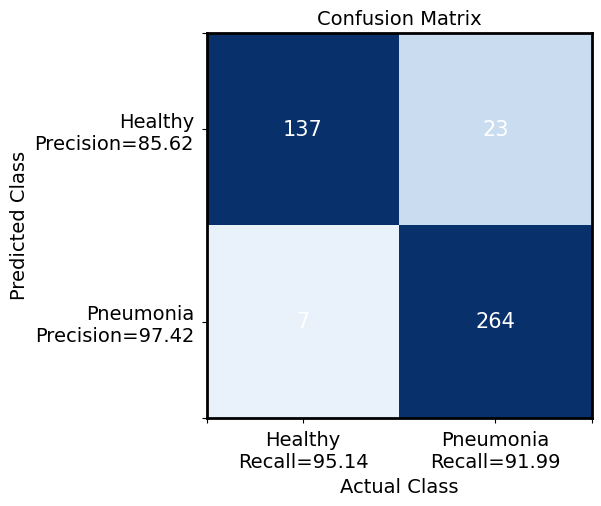

+ Printing ROC curve...



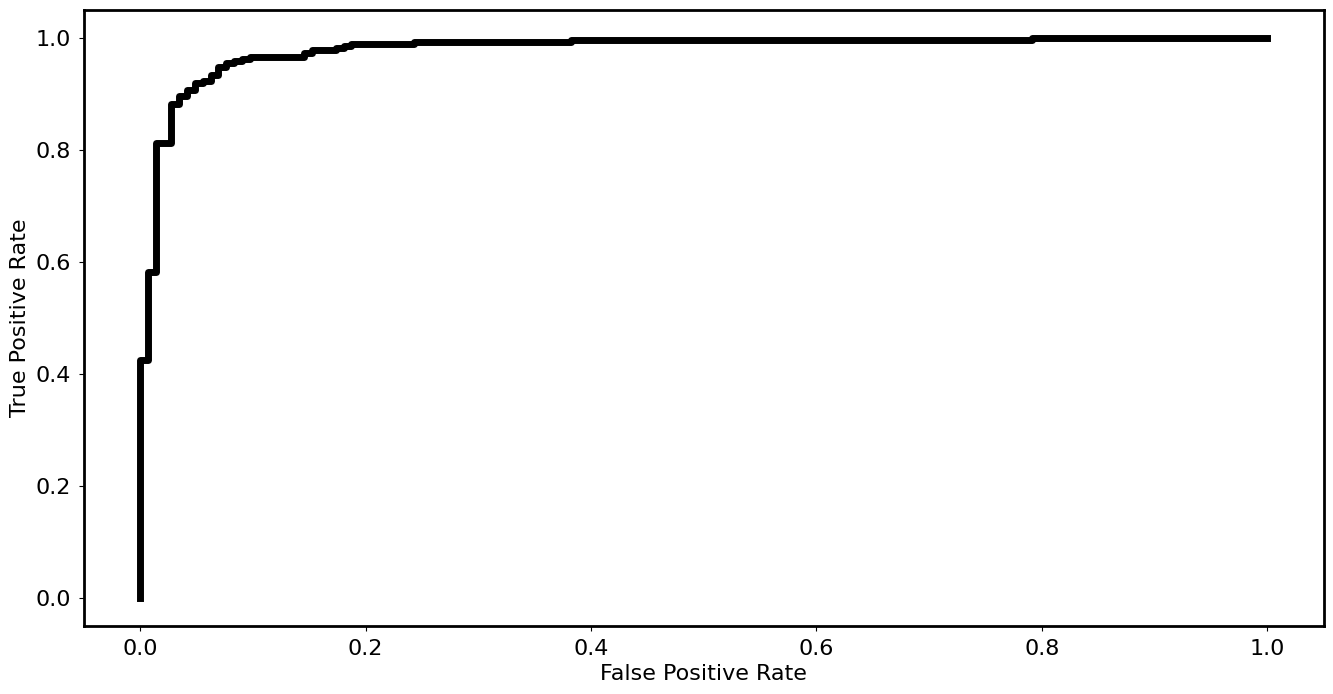

98.0

In [21]:
# bestAcc = 0.0
bestAUC = 0.0
bestEpoch = 0
# bestAccPredictions, bestAccPredictionProbabilities = [], []
bestAUCPredictions, bestAUCPredictionProbabilities = [], []

print("+ Starting training. Each epoch can take about 2-5 minutes, hold tight!")
print("-----------------------------------------------------------------------\n")
for epoch in range(epochs):
    
    #################################################### Model Training ###############################################################
    if USE_DATA_AUGMENTATION == True:
        # Use data augmentation in alternate epochs
        #if epoch % 2 == 0:
        if True:
            # Alternate between training with and without augmented data. Training just on the augmented data might not be the best way to go.
            ############ You can change the "epoch % 2" to some other integer value to train on top of the augmented data 
            ############ after a certain number of epochs e.g "epoch % 3" will train on augmented data after every 2 epochs ############
            model.fit_generator(dataAugmentation.flow(trainData, trainLabels, batch_size=batchSize),
                        steps_per_epoch=len(trainData) / batchSize, epochs=1, verbose = 2)
        else:
            model.fit(trainData, trainLabels, batch_size=batchSize, epochs=1, verbose = 2)
    else:
        # Do not use data augmentation
        model.fit(trainData, trainLabels, batch_size=batchSize, epochs=1, verbose = 2)
    
    
    #################################################### Model Testing ###############################################################
    # Calculate test accuracy
    accuracy = round(model.evaluate(testData, testLabels)[1] * 100, 3)
    predictions = model.predict(testData)
    AccPredictionProbabilities = model.predict(testData)
    AccPredictions = [1 if item[1] > item[0] else 0 for item in AccPredictionProbabilities]
    epochAUC = calculateMetrics(AccPredictions, AccPredictionProbabilities, testLabels)
    print("+ Test accuracy at epoch %d is: %.2f " % (epoch, accuracy))
    print("+ Test AUC at epoch %d is: %.3f " % (epoch, epochAUC))
    outputFile = open("results/Log.txt", "a")
    outputFile.write("Epoch-Accuracy-AUC \t %d \t %.2f \t %.3f \n" % (epoch, accuracy,epochAUC))
    outputFile.close()
    
    #if accuracy > bestAcc:
    #    bestEpoch = epoch
    #    bestAcc = accuracy
    #    bestAccPredictions = [1 if item[1] > item[0] else 0 for item in predictions]
    #    bestAccPredictionProbabilities = predictions
    #    
    #    ##################################### Store predictions for kaggle ###########################################################
    #    kaggleResultsFileName = "epoch-" + str(epoch) + "-results.csv"
    #    getKagglePredictions(model, kaggleTestImages, kaggleResultsFileName)
    #    ##############################################################################################################################
    #print('\n')

    if epochAUC > bestAUC:
        bestEpoch = epoch
        bestAUC = epochAUC
        bestAUCPredictions = [1 if item[1] > item[0] else 0 for item in predictions]
        bestAUCPredictionProbabilities = predictions
        
        ##################################### Store predictions for kaggle ###########################################################
        
        ##############################################################################################################################
    kaggleResultsFileName = "epoch-" + str(epoch) + "-results.csv"
    getKagglePredictions(model, kaggleTestImages, kaggleResultsFileName)
    print('\n')

print("------------------------------------------------------------------------")


##################################################### Printing best metrics ##########################################################
# Get more metrics for the best performing epoch
#print("\n*** Printing our best validation results that we obtained in epoch %d ..." % bestEpoch)
#calculateMetricsAndPrint(bestACCPredictions, bestACCPredictionProbabilities, testLabels)

print("\n*** Printing our best validation results that we obtained in epoch %d ..." % bestEpoch)
calculateMetricsAndPrint(bestAUCPredictions, bestAUCPredictionProbabilities, testLabels)

## 4.4 Top n% Predictions

In [22]:
################################## You can change values inside the following list ###########################
#topNValues = [10, 20, 30, 40]
##############################################################################################################

#accuraciesHealthy, accuraciesPneumonia = [], []
#for topn in topNValues:
#    accuracyHealthy, accuracyPneumonia = calculateClasswiseTopNAccuracy(testLabels, bestAccPredictionProbabilities, topn)
#    accuraciesHealthy.append(accuracyHealthy)
#    accuraciesPneumonia.append(accuracyPneumonia)
    
#    print("+ Accuracy for top %d percent predictions for healthy: %.2f, pneumonia: %.2f" % (topn, accuracyHealthy, accuracyPneumonia))
    
# Plot results
#x = np.arange(len(accuraciesHealthy))
#plt.plot(x, accuraciesHealthy, linewidth = 3, color = '#e01111')
#scatterHealthy = plt.scatter(x, accuraciesHealthy, marker = 's', s = 100, color = '#e01111')
#plt.plot(x, accuraciesPneumonia, linewidth = 3, color = '#0072ff')
#scatterPneumonia = plt.scatter(x, accuraciesPneumonia, marker = 'o', s = 100, color = '#0072ff')
#plt.xticks(x, topNValues, fontsize = 15)
#plt.yticks(fontsize = 15)
#plt.xlabel("Top N%", fontsize = 15)
#plt.ylabel("Accuracy", fontsize = 15)
#plt.legend([scatterHealthy, scatterPneumonia], ["Accuracy for Healthy", "Accuracy for Pneumonia"], fontsize = 17)
#plt.ylim(0, 110)
#plt.show()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a752148d-e9f7-4923-b489-b7ea09d643d8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>